# Linear Classifier with Gradient Descent

--- 

In this lab, we will explore the implementation of a linear classifier from scratch. The topics covered include:

- Initialization of weights and bias
- Matrix multiplication of inputs (X) and weights (theta) with bias
- Loss (cost) function calculation
- Gradient Descent (both batch and stochastic)
- Weight update
- Use case for binomial and multinomial classification using sigmoid and softmax

---

## 0. Import necessary libraries

In [1]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import torch.nn as nn
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
from torchvision import models


## 1. Initialization of Weights and Bias

Before training, we need to initialize our weights (`theta`) and bias (`b`). This can be done randomly or using a small constant value. In most cases, initializing weights with small random values works best to break symmetry, while bias can be initialized to zero.

## 2. Matrix Multiplication of $X$ and $\theta$ with Bias

In linear models, the prediction is computed as the dot product between the input features $X$ and the weight vector $\theta$, plus the bias $b$. Mathematically, this is expressed as:

$$ 
y = X\theta + b 
$$

To incorporate the bias term into the matrix multiplication, we can augment the input matrix $X$ and the weight vector $\theta$. 

### i. Augmenting $X$

Add a column of ones to the input matrix $X$ to account for the bias term. Let $X$ have dimensions $m \times n$ (where $m$ is the number of samples and $n$ is the number of features). The augmented matrix $X_{\text{bias}}$ will have dimensions $m \times (n+1)$:

$$
X_{\text{bias}} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1n} \\
1 & x_{21} & x_{22} & \cdots & x_{2n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{m1} & x_{m2} & \cdots & x_{mn}
\end{bmatrix}
$$

### ii. Augmenting $\theta$

Extend $\theta$ to include the bias term. The extended vector $\theta_{\text{bias}}$ will have dimensions $(n+1) \times c$ (where c is the no. of classes):

$$
\theta_{\text{bias}} = \begin{bmatrix}
b \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_n
\end{bmatrix}
$$

### iii. Matrix Multiplication

With the augmented matrix $X_{\text{bias}}$ and the extended vector $\theta_{\text{bias}}$, the prediction $y$ can be computed as:

$$
y = X_{\text{bias}} \theta_{\text{bias}}
$$

This approach simplifies the computation by integrating the bias term directly into the matrix multiplication, which can be more efficient and straightforward in practice, especially when using matrix operations libraries.


In [2]:
# Add bias term (column of 1s) to X
def add_bias_term(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

In [3]:
# Initialize weights with X updated to handle bias
def initialize_parameters(X, y, multiclass):
    n_features = X.shape[1]  # Number of features from the input X with bias term
    if multiclass:
        n_classes = y.shape[1]
        theta = np.random.randn(n_features, n_classes) * 0.01  # Small random weights
    else:
        theta = np.random.randn(n_features, 1) * 0.01  # Small random weights
    return theta

In [4]:
# Linear prediction
def linear_prediction(X, theta):
    return np.dot(X, theta)

## 3. Loss Functions for Classification

For classification tasks, different loss functions are used depending on whether the task is binary classification or multinomial classification.

### Binary Classification (Sigmoid/Logistic Regression)

The loss function used is binary cross-entropy, also known as log loss. It is defined as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

where:
- $m$ is the number of samples.
- $y_i$ is the true label for the $i$-th sample.
- $\hat{y}_i$ is the predicted probability for the $i$-th sample.

### Multinomial Classification (Softmax)

For multinomial classification, especially after one-hot encoding the labels, the loss function is categorical cross-entropy. It is defined as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})
$$

where:
- $m$ is the number of samples.
- $K$ is the number of classes.
- $y_{ik}$ is the one-hot encoded label for the $i$-th sample and $k$-th class (binary indicator: 0 or 1).
- $\hat{y}_{ik}$ is the predicted probability of class $k$ for the $i$-th sample.

In one-hot encoding, $y_{ik}$ is 1 if the $i$-th sample belongs to class $k$, and 0 otherwise. This loss function measures how well the predicted probabilities match the one-hot encoded true labels.

In [5]:
# Binary Cross Entropy Loss
def binary_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15  # To avoid log(0) this is a very small value
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m

# Categorical Cross Entropy Loss
def categorical_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / m

## 4. Gradient Descent for Minimizing the Loss Function with weight updates

Gradient descent is used to minimize the loss function by iteratively updating the weights based on the gradient of the loss function.

### Batch Gradient Descent

In Batch Gradient Descent, the gradient is computed using all examples in the dataset:

$$
\theta = \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}
$$

where:
- $\alpha$ is the learning rate.
- $\frac{\partial J(\theta)}{\partial \theta}$ is the gradient of the loss function with respect to the weights.

### Stochastic Gradient Descent (SGD)

In Stochastic Gradient Descent, the gradient is computed using only one example at a time:

$$
\theta = \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}
$$

where:
- $\alpha$ is the learning rate.
- $\frac{\partial J(\theta)}{\partial \theta}$ is the gradient of the loss function with respect to the weights, computed for a single example.

In both cases, the update rule for weights is the same, but the difference lies in how the gradient is computed: either over the entire dataset (Batch Gradient Descent) or a single example (Stochastic Gradient Descent).


## 5. Weight Update
After calculating the gradient, we update the weights using the formula mentioned above. Depending on whether we are using batch gradient descent or stochastic gradient descent, the weight update happens differently.

In [6]:
def gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass):
    m = X.shape[0]
    # predictions = linear_prediction(X, theta)
    if multiclass:
        # predictions = softmax(predictions)
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    else:
        # predictions = sigmoid(predictions)
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    theta = theta - learning_rate * gradients
    return theta

In [7]:
# Stochastic Gradient Descent (SGD) Step
def stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass):
    m = X.shape[0]
    for i in range(m):
        xi = X[i:i+1]
        yi = y[i:i+1]
        # print (theta.shape)
        prediction = linear_prediction(xi, theta)
        if multiclass:
            prediction = softmax(prediction)
        else:
            prediction = sigmoid(prediction)
        # print(prediction.shape)
        # print(xi.T.shape)
        # print(yi.shape)
        gradients = np.dot(xi.T, (prediction - yi))
        theta = theta - learning_rate * gradients
    return theta


## Activation: Binomial Classification (Sigmoid)

In binary classification, the sigmoid function is applied to the linear output to obtain the predicted probability. The sigmoid function $\sigma(z)$ is defined as:

$$
\hat{y} = \sigma(X \theta) = \frac{1}{1 + e^{-X \theta}}
$$

where:
- $\hat{y}$ is the predicted probability.
- $X \theta$ represents the linear combination of the input features $X$ and the weights $\theta$.
- $e$ is the base of the natural logarithm.

The sigmoid function maps the linear output to a probability value between 0 and 1, which can then be used to make a classification decision.

## Activation: Multinomial Classification (Softmax)

In multinomial classification, the softmax function is used to compute probabilities across multiple classes. The softmax function $\text{softmax}(z_i)$ for class $k$ is defined as:

$$
\hat{y}_{ik} = \frac{e^{(X \theta_k)}}{\sum_{j=1}^{K} e^{(X \theta_j)}}
$$

where:
- $\hat{y}_{ik}$ is the predicted probability of the $i$-th sample belonging to class $k$.
- $X \theta_k$ is the linear combination of the input features $X$ and the weights $\theta_k$ for class $k$.
- $K$ is the total number of classes.
- The denominator is the sum of the exponentials of the linear combinations for all classes, ensuring that the probabilities sum up to 1.

The softmax function converts the linear outputs into a probability distribution over multiple classes, which is useful for making predictions in multiclass classification problems.


In [8]:
# Sigmoid function for binary classification
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Softmax function for multi-class
def softmax(z):
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

### OKAY LETS GO A HEAD AND TRAIN OUR MODEL !!

In [9]:
# Training function
def train_model(X, y, learning_rate=0.01, iterations=1000, batch=True, multiclass=False):
    # Add bias term to X
    X = add_bias_term(X)
    
    # Initialize theta
    theta = initialize_parameters(X, y, multiclass)
    
    # Track loss over iterations
    losses = []
    
    for i in range(iterations):
        # Compute predictions and loss
        if multiclass:
            predictions = softmax(linear_prediction(X, theta))
            loss = categorical_cross_entropy_loss(y, predictions)
        else:
            predictions = sigmoid(linear_prediction(X, theta))
            loss = binary_cross_entropy_loss(y, predictions)
        
        losses.append(loss)
        
        # Update weights
        if batch:
            theta = gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass)
        else:
            # Use stochastic gradient descent
            theta = stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass)
        
        # Print loss every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i}/{iterations}, Loss: {loss:.4f}")
    
    return theta, losses

### Lets generate some data!!

In [10]:
# Set multiclass to True or False
multiclass = True  # Set to True for multiclass classification

if multiclass:
    # For multiclass classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=3, n_informative=3, 
                                   n_redundant=0, n_clusters_per_class=1, n_classes=4, random_state=100)
    # Convert y to one-hot encoding
    y_syn = np.eye(np.max(y_syn) + 1)[y_syn]
else:
    # For binary classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=100)
    y_syn = y_syn.reshape(-1, 1)  # Reshape y to be a column vector

# Split into training and test sets
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.2, random_state=100)

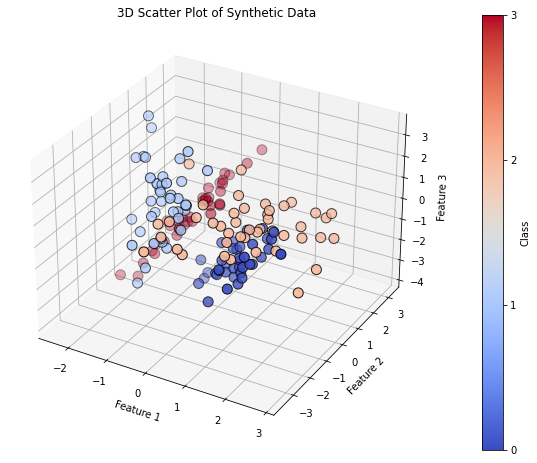

In [11]:
if multiclass:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Convert one-hot encoding to class labels for plotting
    y_train_labels = np.argmax(y_train_syn, axis=1)

    # Use the 3 features for the scatter plot
    scatter = ax.scatter(X_train_syn[:, 0], X_train_syn[:, 1], X_train_syn[:, 2], 
                         c=y_train_labels, cmap='coolwarm', edgecolor='k', s=100)

    # Add labels
    ax.set_title("3D Scatter Plot of Synthetic Data")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")

    # Add color bar to represent class labels
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Class')
    
    # Set ticks to be integers corresponding to class labels
    cbar.set_ticks(np.arange(np.min(y_train_labels), np.max(y_train_labels) + 1))

    plt.show()
else:
    plt.figure(figsize=(10, 8))
    plt.scatter(X_train_syn[:, 0], X_train_syn[:, 1], c=y_train_syn, cmap='coolwarm', edgecolor='k', s=100)
    plt.title("Scatter Plot of Training Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
    

In [12]:
start_time = time.time()
theta, losses = train_model(X_train_syn, y_train_syn, learning_rate=0.01, iterations=1000, batch=True, multiclass=multiclass)
print(f"Time Taken Using Batch gradient descent :{time.time() - start_time}")

Iteration 0/1000, Loss: 1.3832
Iteration 100/1000, Loss: 0.9343
Iteration 200/1000, Loss: 0.7356
Iteration 300/1000, Loss: 0.6275
Iteration 400/1000, Loss: 0.5600
Iteration 500/1000, Loss: 0.5140
Iteration 600/1000, Loss: 0.4806
Iteration 700/1000, Loss: 0.4553
Iteration 800/1000, Loss: 0.4354
Iteration 900/1000, Loss: 0.4194
Time Taken Using Batch gradient descent :0.11540985107421875


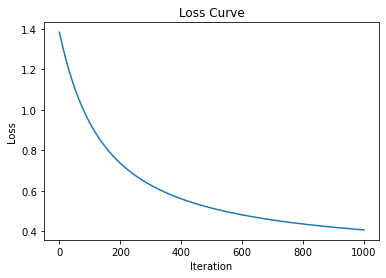

In [13]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [14]:
# Add bias term to test data
X_test_bias = add_bias_term(X_test_syn)

if multiclass:
    predictions = softmax(linear_prediction(X_test_bias, theta))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_syn, axis=1)
else:
    predictions = sigmoid(linear_prediction(X_test_bias, theta))
    predicted_classes = (predictions >= 0.5).astype(int)
    true_classes = y_test_syn

# Calculate accuracy
accuracy = np.mean(predicted_classes.flatten() == true_classes.flatten())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 90.00%


In [15]:
start_time = time.time()
theta, losses = train_model(X_train_syn, y_train_syn, learning_rate=0.01, iterations=1000, batch=False, multiclass=multiclass)
print(f"Time Taken Using Stochastic gradient descent :{time.time() - start_time}")

Iteration 0/1000, Loss: 1.3847
Iteration 100/1000, Loss: 0.2755
Iteration 200/1000, Loss: 0.2695
Iteration 300/1000, Loss: 0.2675
Iteration 400/1000, Loss: 0.2666
Iteration 500/1000, Loss: 0.2660
Iteration 600/1000, Loss: 0.2657
Iteration 700/1000, Loss: 0.2654
Iteration 800/1000, Loss: 0.2653
Iteration 900/1000, Loss: 0.2652
Time Taken Using Stochastic gradient descent :4.87663459777832


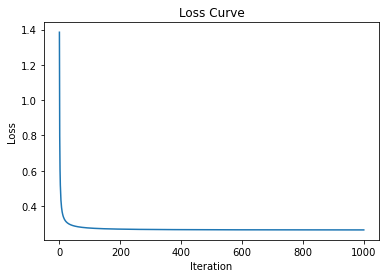

In [16]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [17]:
# Add bias term to test data
X_test_bias = add_bias_term(X_test_syn)

if multiclass:
    predictions = softmax(linear_prediction(X_test_bias, theta))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_syn, axis=1)
else:
    predictions = sigmoid(linear_prediction(X_test_bias, theta))
    predicted_classes = (predictions >= 0.5).astype(int)
    true_classes = y_test_syn

# Calculate accuracy
accuracy = np.mean(predicted_classes.flatten() == true_classes.flatten())
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 92.50%


## For Image what could be possible changes??

In [18]:
# For our puffer surver we need to browse via a proxy!!

# Set HTTP and HTTPS proxy
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [19]:
# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [20]:
cifar_train = datasets.CIFAR10('../LAB_04/data', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('../LAB_04/data', train=False, download=True ,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

# Subsample the training and test datasets
sample_size = 1000
train_subset = subsample_dataset(cifar_train, sample_size=sample_size)
test_subset = subsample_dataset(cifar_test, sample_size=int(sample_size * 0.4))

# Load data into PyTorch DataLoader
train_loader = DataLoader(train_subset, batch_size=sample_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=int(sample_size * 0.4), shuffle=False)

# Fetch all data and labels for easier handling
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Before Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Reshape the images to 2D for the KNN algorithm
X_train = X_train.view(X_train.size(0), -1).to(device)  # Flatten
X_test = X_test.view(X_test.size(0), -1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("After Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Before Flattening
Training data shape: torch.Size([1000, 3, 32, 32])
Test data shape: torch.Size([400, 3, 32, 32])
After Flattening
Training data shape: torch.Size([1000, 3072])
Test data shape: torch.Size([400, 3072])


In [22]:
class ImageLinearClassifier:
    def __init__(self, input_size, n_classes):
        self.W = np.random.randn(n_classes, input_size) * 0.01  # Small random weights (10,3072)
        self.b = np.zeros((n_classes, 1))  # Bias initialized to zero (10,1)

    def predict(self, X):
        # Reshape X to (input_size, batch_size)
        X=X.T  # Transpose to shape (3072,1000)
        return np.dot(self.W, X) + self.b

    def compute_loss(self, X, y):
        """
            X: (batch_size, input_size) = (1000, 3072)
            y: (batch_size,) = (1000,) with class labels (0-9)
        """
        m = X.shape[0]
        z = self.predict(X)
        probs = self.softmax(z)
        log_likelihood = -np.log(probs[y, range(m)])
        return np.sum(log_likelihood) / m

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def gradient_descent(self, X, y, learning_rate=0.001):
        # Compute the gradient and update W, b
        m = X.shape[0]
        z = self.predict(X)
        probs = self.softmax(z)
        probs[y, range(m)] -= 1  # Gradient of softmax loss wrt z
        dW = np.dot(probs, X) / m  #Gradient wrt weights
        db = np.sum(probs, axis=1, keepdims=True) / m
        
        # Update weights and bias
        self.W -= learning_rate * dW
        self.b -= learning_rate * db


In [23]:
def train(classifier, X_train, y_train, epochs, learning_rate):
    losses = []
    for i in range(epochs):
        loss = classifier.compute_loss(X_train, y_train)
        losses.append(loss)
        print(f'Epoch {i+1}, Loss: {loss}')
        classifier.gradient_descent(X_train, y_train, learning_rate)
    return losses

In [24]:
print(f"Training data: {len(cifar_train)}")
print(f"Test data: {len(cifar_test)}")

image, label = cifar_train[0]
# Now you can check the shape of the image
print(f"Image shape: {image.shape}")

Training data: 50000
Test data: 10000
Image shape: torch.Size([3, 32, 32])


In [25]:
# Example usage
n_classes = 10  # For CIFAR-10
image_size = 32 * 32 * 3  # CIFAR-10 images are 32x32x3
classifier = ImageLinearClassifier(input_size=image_size, n_classes=n_classes)

# X_train is shape (image_size, batch_size) and y_train is (batch_size,)
losses = train(classifier, X_train, y_train, epochs=100, learning_rate=0.01)

Epoch 1, Loss: 2.3304049007235244
Epoch 2, Loss: 2.287276283110353
Epoch 3, Loss: 2.2742305920019072
Epoch 4, Loss: 2.2648641862213035
Epoch 5, Loss: 2.2562884338556035
Epoch 6, Loss: 2.24807288302408
Epoch 7, Loss: 2.2401503632463027
Epoch 8, Loss: 2.2325006646169703
Epoch 9, Loss: 2.225109864392534
Epoch 10, Loss: 2.2179653966146318
Epoch 11, Loss: 2.211055410306573
Epoch 12, Loss: 2.2043686632259583
Epoch 13, Loss: 2.1978944881247684
Epoch 14, Loss: 2.1916227692378647
Epoch 15, Loss: 2.185543919837034
Epoch 16, Loss: 2.179648859541945
Epoch 17, Loss: 2.1739289913805266
Epoch 18, Loss: 2.1683761788111506
Epoch 19, Loss: 2.162982722932181
Epoch 20, Loss: 2.1577413400739913
Epoch 21, Loss: 2.1526451399307374
Epoch 22, Loss: 2.1476876043532847
Epoch 23, Loss: 2.1428625668931343
Epoch 24, Loss: 2.13816419316034
Epoch 25, Loss: 2.133586962036072
Epoch 26, Loss: 2.1291256477620863
Epoch 27, Loss: 2.124775302914536
Epoch 28, Loss: 2.120531242257661
Epoch 29, Loss: 2.1163890274636326
Epoch 3

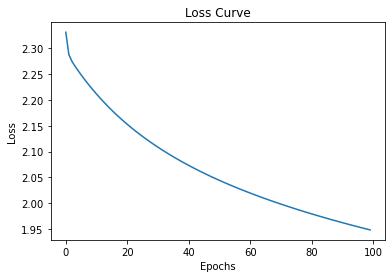

In [26]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

## Key Components:
1. Input Layer: The input data, similar to your previous setup.
2. Hidden Layer(s): These layers will have weights, biases, and non-linear activations like ReLU.
3. Output Layer: This will have a softmax activation for classification.
4. Loss Function: Cross-entropy loss for classification.
5. Backpropagation: To update weights using gradients from the loss.

## MLP Structure Example:
1. Input Layer: (3072 neurons, corresponding to image size 32x32x3 in CIFAR-10)
2. Hidden Layer 1: Fully connected, with a non-linear activation like ReLU.
3. Hidden Layer 2: Another fully connected layer (optional).
4. Output Layer: A fully connected layer with 10 neurons (for 10 classes) and softmax activation.

In [27]:
class MLPClassifier:
    def __init__(self, input_size, hidden_size, output_size):
        # Weight initialization
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01  # (hidden_size, input_size)
        self.b1 = np.zeros((hidden_size, 1))  # (hidden_size, 1)
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01  # (output_size, hidden_size)
        self.b2 = np.zeros((output_size, 1))  # (output_size, 1)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass through the network.
        X: input data of shape (input_size, batch_size)
        """
        # Layer 1 (hidden layer)
        self.Z1 = np.dot(self.W1, X) + self.b1  # (hidden_size, batch_size)
        self.A1 = self.relu(self.Z1)  # Apply ReLU activation
        
        ## ADD ANOTHER HIDDEN LAYER IN YOUR TAKE HOME EXERCISE

        # Layer 2 (output layer)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2  # (output_size, batch_size)
        self.A2 = self.softmax(self.Z2)  # Apply softmax activation
        return self.A2
    
    def compute_loss(self, A2, y):
        """
        Compute cross-entropy loss.
        A2: output from softmax, shape (output_size, batch_size)
        y: true labels, shape (batch_size,)
        """
        m = y.shape[0]  # batch size
        log_likelihood = -np.log(A2[y, range(m)])
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, X, y, learning_rate=0.01):
        """
        Perform backward propagation and update weights.
        X: input data of shape (input_size, batch_size)
        y: true labels of shape (batch_size,)
        """
        m = X.shape[1]  # Batch size
        
        # Gradient of the loss w.r.t. Z2
        dZ2 = self.A2  # Softmax probabilities
        dZ2[y, range(m)] -= 1  # Subtract 1 from the correct class probabilities
        dZ2 /= m
        
        # Gradients for W2 and b2
        dW2 = np.dot(dZ2, self.A1.T)  # (output_size, hidden_size)
        db2 = np.sum(dZ2, axis=1, keepdims=True)  # (output_size, 1)
        
        # Gradients for the hidden layer (backprop through ReLU)
        dA1 = np.dot(self.W2.T, dZ2)  # (hidden_size, batch_size)
        dZ1 = dA1 * self.relu_derivative(self.Z1)  # Backprop through ReLU
        
        # Gradients for W1 and b1
        dW1 = np.dot(dZ1, X.T)  # (hidden_size, input_size)
        db1 = np.sum(dZ1, axis=1, keepdims=True)  # (hidden_size, 1)
        
        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    
    def train(self, X_train, y_train, epochs=100, learning_rate=0.01):
        """
        Train the network.
        X_train: input data, shape (input_size, batch_size)
        y_train: true labels, shape (batch_size,)
        """
        losses = []
        for i in range(epochs):
            # Forward pass
            A2 = self.forward(X_train)
            
            # Compute the loss
            loss = self.compute_loss(A2, y_train)
            print(f'Epoch {i+1}, Loss: {loss}')
            losses.append(loss)
            
            # Backward pass
            self.backward(X_train, y_train, learning_rate)
        return losses


In [28]:
input_size = 3072  # CIFAR-10 images are 32x32x3
hidden_size = 100  # Arbitrary hidden layer size
output_size = 10  # 10 classes for CIFAR-10

mlp = MLPClassifier(input_size, hidden_size, output_size)

X_train_copy = X_train.T

losses = mlp.train(X_train_copy, y_train, epochs=100, learning_rate=0.1)

Epoch 1, Loss: 2.302355374060994
Epoch 2, Loss: 2.299853177391281
Epoch 3, Loss: 2.2975974559576366
Epoch 4, Loss: 2.295492334861766
Epoch 5, Loss: 2.2934228384245516
Epoch 6, Loss: 2.291342372439294
Epoch 7, Loss: 2.2892346736474494
Epoch 8, Loss: 2.2871147814729693
Epoch 9, Loss: 2.2849892607400557
Epoch 10, Loss: 2.2828621200387857
Epoch 11, Loss: 2.280724138787242
Epoch 12, Loss: 2.278568867491627
Epoch 13, Loss: 2.276337765541998
Epoch 14, Loss: 2.273979308180716
Epoch 15, Loss: 2.2714220939878413
Epoch 16, Loss: 2.268622357740994
Epoch 17, Loss: 2.2655360333298793
Epoch 18, Loss: 2.262131620413363
Epoch 19, Loss: 2.2584277533219828
Epoch 20, Loss: 2.254374770210219
Epoch 21, Loss: 2.249954676625499
Epoch 22, Loss: 2.2451471396375537
Epoch 23, Loss: 2.2399334015779995
Epoch 24, Loss: 2.23432129190244
Epoch 25, Loss: 2.228329836602421
Epoch 26, Loss: 2.2219856188883407
Epoch 27, Loss: 2.2153121891146355
Epoch 28, Loss: 2.2083530868670285
Epoch 29, Loss: 2.2011620901610573
Epoch 30,

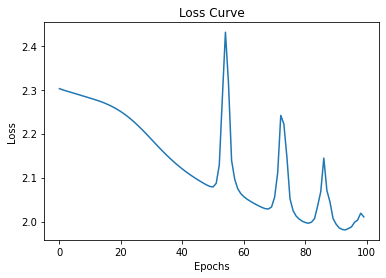

In [29]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

## TAKE AWAY EXERCISE

- In the picture above the learning rate is high so the model is not able to find a minima and is overshooting.
- Use a learning rate scheduler in the above implementation, increase the no. of epochs and train on full data.
- Also increase the complexity of structure by adding another hidden layer

In [30]:
# your code here
class MLPClassifier:
    def __init__(self, input_size, hidden_size, output_size):
        # Weight initialization
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01  # (hidden_size, input_size)
        self.b1 = np.zeros((hidden_size, 1))  # (hidden_size, 1)
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01  # (output_size, hidden_size)
        self.b2 = np.zeros((output_size, 1))  # (output_size, 1)
        self.W3 = np.random.randn(hidden_size, hidden_size) * 0.01  # (hidden_size, hidden_size)
        self.b3 = np.zeros((hidden_size, 1))  # (hidden_size, 1)
        self.best_loss = float('inf')
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass through the network.
        X: input data of shape (input_size, batch_size)
        """
        # Layer 1 (hidden layer)
        self.Z1 = np.dot(self.W1, X) + self.b1  # (hidden_size, batch_size)
        self.A1 = self.relu(self.Z1)  # Apply ReLU activation
        
        ## ADD ANOTHER HIDDEN LAYER IN YOUR TAKE HOME EXERCISE
        self.Z3 = np.dot(self.W3, self.A1) + self.b3  # (hidden_size, batch_size)
        self.A3 = self.relu(self.Z3)  # Apply ReLU activation

        # Layer 2 (output layer)
        self.Z2 = np.dot(self.W2, self.A3) + self.b2  # (output_size, batch_size)
        self.A2 = self.softmax(self.Z2)  # Apply softmax activation
        return self.A2
    
    def compute_loss(self, A2, y):
        """
        Compute cross-entropy loss.
        A2: output from softmax, shape (output_size, batch_size)
        y: true labels, shape (batch_size,)
        """
        m = y.shape[0]  # batch size
        epsilon = 1e-10  # Small value to prevent log(0)
        log_likelihood = -np.log(A2[y, range(m)] + epsilon)

        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, X, y, learning_rate=0.01, clip_threshold=1.0):
        """
        Perform backward propagation and update weights, with gradient clipping.
        X: input data of shape (input_size, batch_size)
        y: true labels of shape (batch_size,)
        clip_threshold: the maximum allowed value for gradients, used to clip them
        """
        m = X.shape[1]  # Batch size

        # Gradient of the loss w.r.t. Z2
        dZ2 = self.A2  # Softmax probabilities
        dZ2[y, range(m)] -= 1  # Subtract 1 from the correct class probabilities
        dZ2 /= m

        # Gradients for W2 and b2
        dW2 = np.dot(dZ2, self.A3.T)  # (output_size, hidden_size)
        db2 = np.sum(dZ2, axis=1, keepdims=True)  # (output_size, 1)

        # Gradients for the second hidden layer
        dA3 = np.dot(self.W2.T, dZ2)  # (hidden_size, batch_size)
        dZ3 = dA3 * self.relu_derivative(self.Z3)  # Backprop through ReLU

        # Gradients for W3 and b3
        dW3 = np.dot(dZ3, self.A1.T)  # (hidden_size, hidden_size)
        db3 = np.sum(dZ3, axis=1, keepdims=True)  # (hidden_size, 1)

        # Gradients for the first hidden layer
        dA1 = np.dot(self.W3.T, dZ3)  # (hidden_size, batch_size)
        dZ1 = dA1 * self.relu_derivative(self.Z1)  # Backprop through ReLU

        # Gradients for W1 and b1
        dW1 = np.dot(dZ1, X.T)  # (hidden_size, input_size)
        db1 = np.sum(dZ1, axis=1, keepdims=True)  # (hidden_size, 1)

        # Clip gradients to avoid exploding gradients
        dW1 = np.clip(dW1, -clip_threshold, clip_threshold)
        db1 = np.clip(db1, -clip_threshold, clip_threshold)
        dW2 = np.clip(dW2, -clip_threshold, clip_threshold)
        db2 = np.clip(db2, -clip_threshold, clip_threshold)
        dW3 = np.clip(dW3, -clip_threshold, clip_threshold)
        db3 = np.clip(db3, -clip_threshold, clip_threshold)

        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3

    
    def train(self, train_loader, epochs=100, learning_rate=0.01, step_size=100, gamma=0.5, patience = 5, min_delta=0.01):
        """
        Train the network with step decay for the learning rate.
        
        X_train: input data, shape (input_size, batch_size)
        y_train: true labels, shape (batch_size,)
        epochs: number of training epochs
        learning_rate: initial learning rate
        step_size: number of epochs after which to reduce the learning rate
        gamma: factor by which to reduce the learning rate (e.g., 0.1 means 90% reduction)
        """
        losses = []
        current_lr = learning_rate
        epochs_without_improvement = 0

        for i in range(epochs):
            for batch_idx, (X_train, y_train) in enumerate(train_loader):
                X_train = X_train.view(X_train.size(0), -1).to(device).T  # Flatten
                y_train = y_train.to(device)
                # Forward pass
                A2 = self.forward(X_train)
                
                # Compute the loss
                loss = self.compute_loss(A2, y_train)
                # if batch_idx % 10 == 0:
                #     print(f'Epoch {i+1}, Batch {batch_idx}, Loss: {loss}')

                # Backward pass
                self.backward(X_train, y_train, current_lr)
                
#             # # Step decay: Reduce learning rate every 'step_size' epochs
#             if (i + 1) % step_size == 0:
#                 current_lr *= gamma  # Reduce learning rate by a factor of gamma
#                 print(f"Current learning rate: {current_lr}")
            
            print(f'Epoch {i+1}, Loss: {loss}')
            losses.append(loss)

            # Check if loss is close enough to the best loss for early stopping
            if loss < self.best_loss:
                # If the loss improved, update the best loss and reset the counter
                self.best_loss = loss
                epochs_without_improvement = 0  # Reset the counter if we see improvement
            elif abs(loss - self.best_loss) <= min_delta:
                # If loss is close to the best loss (within min_delta), increment the counter
                epochs_without_improvement += 1
            
            # Learning rate scheduler, reduces learning rate (default: by 50%) when loss doesn't improve for half of the patience for early stopping
            if epochs_without_improvement >= patience/2:
                current_lr *= gamma  # Reduce learning rate by a factor of gamma
                print(f"Current learning rate: {current_lr}")
                
            # Early stopping condition
            if epochs_without_improvement >= patience:
                print(f"No significant loss improvement for {patience}, early stopping")
                break

        return losses



In [31]:
# Load data into PyTorch DataLoader
train_loader = DataLoader(cifar_train, batch_size=sample_size, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=int(sample_size * 0.4), shuffle=False)

# Fetch all data and labels for easier handling
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Before Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Reshape the images to 2D for the KNN algorithm
X_train = X_train.view(X_train.size(0), -1).to(device)  # Flatten
X_test = X_test.view(X_test.size(0), -1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("After Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Before Flattening
Training data shape: torch.Size([1000, 3, 32, 32])
Test data shape: torch.Size([400, 3, 32, 32])
After Flattening
Training data shape: torch.Size([1000, 3072])
Test data shape: torch.Size([400, 3072])


In [32]:
input_size = 3072  # CIFAR-10 images are 32x32x3
hidden_size = 100  # Arbitrary hidden layer size
output_size = 10  # 10 classes for CIFAR-10

mlp = MLPClassifier(input_size, hidden_size, output_size)

losses = mlp.train(train_loader, epochs=500, learning_rate=0.1)

Epoch 1, Loss: 2.301742399766407
Epoch 2, Loss: 2.2987258243515516
Epoch 3, Loss: 2.2651327655462623
Epoch 4, Loss: 2.169229320542623
Epoch 5, Loss: 2.116859089516477
Epoch 6, Loss: 2.1587197555443454
Epoch 7, Loss: 2.0322556014602795
Epoch 8, Loss: 2.0130487128827075
Epoch 9, Loss: 2.028449100076992
Epoch 10, Loss: 1.9946963906680943
Epoch 11, Loss: 2.00015296949154
Epoch 12, Loss: 1.934084817233704
Epoch 13, Loss: 1.9443830706142098
Epoch 14, Loss: 1.9104803427860082
Epoch 15, Loss: 1.949687804462938
Epoch 16, Loss: 1.8480495574467255
Epoch 17, Loss: 1.8386119158799472
Epoch 18, Loss: 1.836574267113099
Epoch 19, Loss: 1.8729075929763814
Epoch 20, Loss: 1.8243571190183425
Epoch 21, Loss: 1.8371585373776227
Epoch 22, Loss: 1.81540176465582
Epoch 23, Loss: 1.727982177684409
Epoch 24, Loss: 1.7403078463206685
Epoch 25, Loss: 1.9207515646757165
Epoch 26, Loss: 1.7437017664209906
Epoch 27, Loss: 1.753798884274286
Epoch 28, Loss: 1.6589460900943882
Epoch 29, Loss: 1.665476255439959
Epoch 30

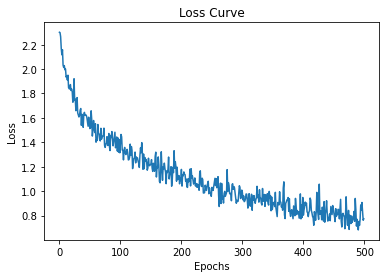

In [33]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()